#Train a simple convnet on the MNIST dataset and evaluate the BALD acquisition function
The acquisition function could then be used for active learning with the images the model is most confused about (highest acquisition function value).
See [Deep Bayesian Active Learning with Image Data](https://arxiv.org/abs/1703.02910).
This code extends on [the Keras CNN example](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py).

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

Couldn't import dot_parser, loading of dot files will not be possible.


Using TensorFlow backend.


# Train a simple convnet with dropout on MNIST:

In [2]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [4]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 6s - loss: 0.3484 - acc: 0.8931 - val_loss: 0.0766 - val_acc: 0.9753
Epoch 2/12
60000/60000 [==============================] - 5s - loss: 0.1151 - acc: 0.9662 - val_loss: 0.0533 - val_acc: 0.9828
Epoch 3/12
60000/60000 [==============================] - 5s - loss: 0.0865 - acc: 0.9745 - val_loss: 0.0450 - val_acc: 0.9847
Epoch 4/12
60000/60000 [==============================] - 5s - loss: 0.0723 - acc: 0.9779 - val_loss: 0.0377 - val_acc: 0.9871
Epoch 5/12
60000/60000 [==============================] - 5s - loss: 0.0626 - acc: 0.9815 - val_loss: 0.0361 - val_acc: 0.9878
Epoch 6/12
60000/60000 [==============================] - 5s - loss: 0.0565 - acc: 0.9831 - val_loss: 0.0379 - val_acc: 0.9866
Epoch 7/12
60000/60000 [==============================] - 5s - loss: 0.0520 - acc: 0.9848 - val_loss: 0.0317 - val_acc: 0.9895
Epoch 8/12
60000/60000 [==============================] - 5s 

# Generate MC samples using keras: 
(we're doing this for the entire test set at once, which requires quite a bit of memory; might be smarter to do this in smaller chunks)

In [8]:
import numpy as np
nb_MC_samples = 100
MC_output = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])

learning_phase = True  # use dropout at test time
MC_samples = [MC_output([x_test, learning_phase])[0] for _ in xrange(nb_MC_samples)]
MC_samples = np.array(MC_samples)  # [#samples x batch size x #classes]

# Approximate the BALD acquisition function:

In [11]:
expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples + 1e-10), axis=-1), axis=0)  # [batch size]
expected_p = np.mean(MC_samples, axis=0)
entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
BALD_acq = entropy_expected_p - expected_entropy
print('BALD_acq on first 10 points', BALD_acq[:10])

BALD_acq on first 10 points [  9.04729241e-05   4.90326760e-03   8.09290912e-04   3.66020016e-03
   2.35900166e-04   6.66706357e-04   1.17769968e-02   7.34678842e-03
   9.32344422e-02   6.72902726e-03]


# Which are the top 5 test images the model is most confused about?

index:  9634 , acq value:  0.703643


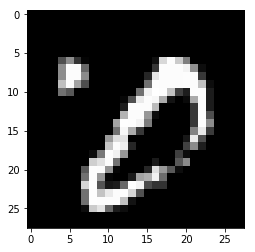

index:  2369 , acq value:  0.619834


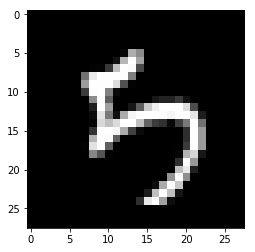

index:  2939 , acq value:  0.606372


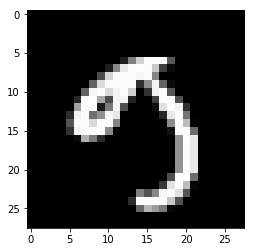

index:  3005 , acq value:  0.591135


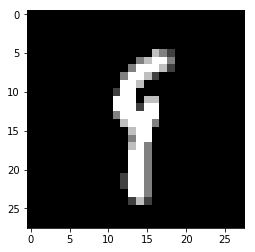

index:  9679 , acq value:  0.579664


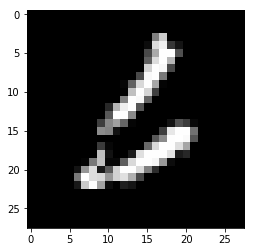

In [21]:
import pylab
%matplotlib inline
for ind in BALD_acq.argsort()[::-1][:5]:  # get the 5 points with highest BALD_acq value
    print('index: ', ind, ', acq value: ', BALD_acq[ind])
    pylab.imshow(x_test[ind].squeeze(), cmap="gray")
    pylab.show()